# MLE Portfolio Project - Customer Churn 

This project is to finish the course `Machine Learning/AI Engineer Career Path` on [CodeCademy](https://www.codecademy.com/) and to showcase what I have learned by implementing some concepts and creating clean and reproducible code.

Dataset: 
I took the data from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download) and it is a dataset showing `Telco Customer Churn`. In the following project I will create machine learning pipelines to make out which models perform best and which features are most predictive of a customer churning.

This type of analysis could be of great help to businesses, as it attacks the problem of trend detection and future readiness.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import seaborn as sns

Let's load and inspect the data!

In [36]:
churn_df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


I see that I won't need the customerID column and I can convert the columns with Yes/No to contain 1/0 valueas.

In [37]:
print(churn_df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


I see that TotalCharges has to be changed to numeric as it is a type "object". I will do that after the train-test split, because I don't want the training set and the test set be interlinked by the fact that the errors in both are filled with the mean of the whole set. 

Let's actually do these changes!

In [38]:
df_churn = churn_df.drop(['customerID'], axis=1)
df_churn["Partner"] = df_churn["Partner"].map({"Yes": 1, "No": 0})
df_churn["Dependents"] = df_churn["Dependents"].map({"Yes": 1, "No": 0})
df_churn["PhoneService"] = df_churn["PhoneService"].map({"Yes": 1, "No": 0})
df_churn["PaperlessBilling"] = df_churn["PaperlessBilling"].map({"Yes": 1, "No": 0})
df_churn["Churn"] = df_churn["Churn"].map({"Yes": 1, "No": 0})

Nice! Now I can do the train-test split and the transformation of the TotalCharges column!

In [39]:
X = df_churn.drop(['Churn'], axis=1)
y = df_churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train["TotalCharges"] = pd.to_numeric(X_train["TotalCharges"], errors='coerce')
X_test["TotalCharges"] = pd.to_numeric(X_test["TotalCharges"], errors='coerce')

X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2142,Female,0,0,1,21,1,No,DSL,Yes,No,Yes,No,No,Yes,One year,0,Mailed check,64.85,1336.80
1623,Female,0,0,0,54,1,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,1,Bank transfer (automatic),97.20,5129.45
6074,Male,0,1,0,1,0,No phone service,DSL,No,No,No,No,No,No,Month-to-month,1,Electronic check,23.45,23.45
1362,Male,0,0,0,4,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.20,237.95
6754,Male,0,0,1,0,1,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,1,Bank transfer (automatic),61.90,NaN


I see that I have some categorical columns and some variables that are continuous, so I will create a pipeline for each.

In [85]:
# Preprocessing for numerical data
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])
# Preprocessing for categorical data
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(sparse = False, drop = "first", handle_unknown = "ignore"))])

# Bundle preprocessing for numerical and categorical data
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),('cat', cat_transformer, cat_cols)])

With this ready, I am able to implement PCA to reduce the number of features and the Logistic Regression Model that I will be using for this project and tune the hyperparameters.

First I will check the accuracy of the pipeline without tuning.

In [86]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(max_iter = 1000))])

pipeline.fit(X_train, y_train)
pipeline_score = pipeline.score(X_test, y_test)
print("The pipeline score is: ", pipeline_score)

The pipeline score is:  0.8218594748048261


In [87]:
print( pipeline.named_steps['classifier'].coef_[0])

[ 0.05922881  0.02708752 -0.0752691  -1.31816341 -0.12459163  0.16503834
 -0.28465059  0.611448   -0.05111451  0.03673889  0.28561993  0.9689038
 -0.14389866 -0.14389866 -0.40628022 -0.14389866 -0.14788018 -0.14389866
  0.00290351 -0.14389866 -0.32462534 -0.14389866  0.25615313 -0.14389866
  0.3585885  -0.64022114 -1.40821863 -0.08640222  0.32305657 -0.03028606]


Visualizing feature importance.

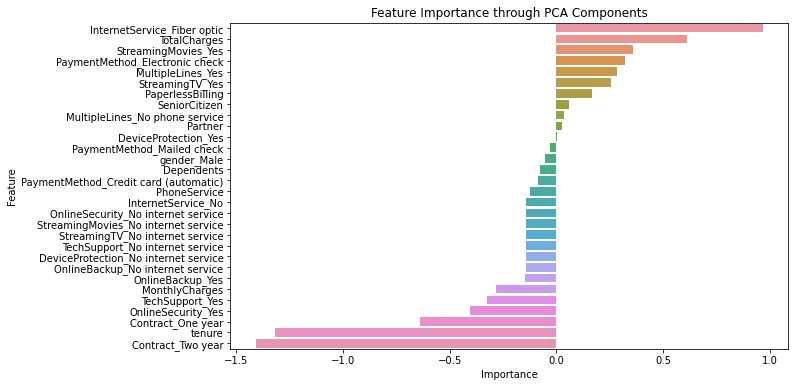

In [90]:
feature_importances = pipeline.named_steps['classifier'].coef_[0]

# Assuming you have a list of original feature names
feature_names = pd.get_dummies(X_train, columns=cat_cols, drop_first=True).columns

# Create a DataFrame of feature importances
importances_df = pd.DataFrame(data={
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance through PCA Components')
plt.show()


Now let the tuning commence!

In [62]:
search_space_1 = [
{
    'pca__n_components': [0.8,0.9,0.95],
    'classifier__C': np.logspace(-2, 2, num=10),
    'classifier__penalty': ['elasticnet'],
    'classifier__solver': ['saga'],
    'classifier__l1_ratio': np.linspace(0.01, 1, num=10)
},
{
    'pca__n_components': [0.8,0.9,0.95],
    'classifier__C': np.logspace(-2, 2, num=10),
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear']
}]
gs1 = GridSearchCV(pipeline, search_space_1, cv=5)
gs1.fit(X_train, y_train)

best_model = gs1.best_estimator_
best_model_score = best_model.score(X_test, y_test)
print("The best Logistic Regression model score is: ", best_model_score)
print("The best Logistic Regression model parameters are: ", gs1.best_params_)

Let's see what the first search looked like!

In [ ]:
hyperparameters = pd.DataFrame(gs1.cv_results_['params'])
scores = pd.DataFrame(gs1.cv_results_['mean_test_score'], columns=['score'])

results = pd.concat([hyperparameters, scores], axis=1).sort_values(by='score', ascending=False)
results.head()

In [ ]:
search_space_2=[{
    'pca__n_components': [0.8,0.9,0.95],
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
},]
gs2 = GridSearchCV(pipeline, search_space_2, cv=5)
gs2.fit(X_train, y_train)

best_model = gs2.best_estimator_
best_model_score = best_model.score(X_test, y_test)
print("The best Random Forest model score is: ", best_model_score)
print("The best Random Forest model parameters are: ", gs2.best_params_)

Let's see what the second search looked like!

In [60]:
hyperparameters = pd.DataFrame(gs2.cv_results_['params'])
scores = pd.DataFrame(gs2.cv_results_['mean_test_score'], columns=['score'])

results = pd.concat([hyperparameters, scores], axis=1).sort_values(by='score', ascending=False)
results.head()

,classifier__C,classifier__l1_ratio,classifier__penalty,classifier__solver,pca__n_components,score
505,0.012743,0.062105,elasticnet,saga,0.80,0.800496
1054,1.623777,0.531053,elasticnet,saga,0.95,0.800319
1099,1.623777,1.000000,elasticnet,saga,0.95,0.800319
1094,1.623777,0.947895,elasticnet,saga,0.95,0.800319
1089,1.623777,0.895789,elasticnet,saga,0.95,0.800319


The best performing model is: 

Now let's see which features are most determinant of a customer churning!

In [ ]:
param_distributions = best_model.get_params()
print(param_distributions)